In [49]:
'''
SOURCE FROM: https://fairyonice.github.io/Achieving-top-5-in-Kaggles-facial-keypoints-detection-using-FCN.html
'''
from IPython.display import IFrame
src = "https://www.youtube.com/embed/8FdSHl4oNIM"
IFrame(src, width=990/2, height=800/2)
import sys, os
print(os.path.dirname(sys.executable))
print(sys.version)

/usr/local/opt/python/bin
3.6.5 (default, Apr 25 2018, 14:23:58) 
[GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.1)]


In [123]:
import os
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.models import model_from_json
print(tf.__version__)
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
#### 1 GPU1
#### 2 GPU2
#### 0 GPU3
#### 4 GPU4
set_session(tf.Session(config=config))

FTRAIN = 'data/sample-training.csv'
FTEST = 'data/test.csv'
FIdLookup = 'data/IdLookupTable.csv'

1.9.0


In [124]:
def load(test=False, cols=None):
    """
    load test/train data
    cols : a list containing landmark label names.
           If this is specified, only the subset of the landmark labels are 
           extracted. for example, cols could be:
           
          [left_eye_center_x, left_eye_center_y]
            
    return: 
    X: 2-d numpy array (Nsample, Ncol*Nrow)
    y: 2-d numpy array (Nsample, Nlandmarks*2) 
       In total there are 15 landmarks. 
       As x and y coordinates are recorded, u.shape = (Nsample,30)
       
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) 

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  
        df = df[list(cols) + ['Image']]

    myprint = df.count()
    myprint = myprint.reset_index()
    
    ## row with at least one NA columns are removed!
    df = df.dropna()  
    
    # changes valeus between 0 and 1. [0, 255] -> [0, 1]. 나중에 image display시 필요.
    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)

    if not test:  # labels only exists for the training data
        ## standardization of the response
        y = df[df.columns[:-1]].values
        # y values are between [-1,1]. 변환과정: [0, 96] -> [-48, 48] -> [-1, 1]
        y = (y - 48) / 48  
        y = y.astype(np.float32)
        X, y = shuffle(X, y, random_state=42)  # shuffle data
    else:
        y = None
    
    
    return X, y

def load2d(test=False, cols=None):

    X, y = load(test, cols)
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html
    # -1 은 알아서 유추.
    # (*, 9216) -> (*, 96, 96, 1)
    X = X.reshape(-1, 96, 96, 1)

    return X, y

def plot_loss(hist, name, plt, RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        # multiply by 48 to get the loss in the original scale. + 48 is not necessary since it's canceled out.
        loss = np.sqrt(np.array(loss)) * 48 
        val_loss = np.sqrt(np.array(val_loss)) * 48 
        
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html
    plt.plot(loss,"--", linewidth=3, label="train:%s" % name)
    plt.plot(val_loss, ':', linewidth=3, label="val: %s" % name)
    
def plot_sample(X, y, axs, color='b'):
    '''
    X: 9216 -> 96 by 96 Image
    y: feature values rescaled to range between -1 and 1
    '''
    # show image
    axs.imshow(X.reshape(96, 96), cmap="gray")
    '''
    https://docs.python.org/release/2.3.5/whatsnew/section-slices.html
    y[0::2] -> y[0], y[2], y[4], y[6], y[8] ...
    y[1::2] -> y[1], y[3], y[5], y[7], y[9] ...
    '''
    # scatter plot of feature points
    axs.scatter(48 * y[0::2] + 48, 48 * y[1::2] + 48, c=color)
    
def save_model(model, name):
    '''
    save model architecture and model weights
    '''
    json_string = model.to_json()
    open('models/%s_architecture.json' % name, 'w').write(json_string)
    model.save_weights('models/%s_weights.h5' % name)
    
def load_model(name):
    model = model_from_json(open('models/%s_architecture.json' % name).read())
    model.load_weights('models/%s_weights.h5' % name)
    return(model)

In [129]:
'''
X.shape = <2140(= number of samples pruned), 9216(= 96*96 = number of image pixels)>
Y.shape = <2140(= number of samples pruned), 30(= number of attributes = 15 facialpoints * 2(xy 좌표 각각 1개씩))>
'''
X, y = load()
# https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html
print("X type: %s, y type: %s" % (type(X), type(y)))
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("X[0]: %s" % str(X[0]))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))
print("y[0]: %s" % str(y[0]))

X type: <class 'numpy.ndarray'>, y type: <class 'numpy.ndarray'>
X.shape == (10, 9216); X.min == 0.000; X.max == 1.000
X[0]: [0.6431373  0.61960787 0.4627451  ... 0.33333334 0.4        0.5411765 ]
y.shape == (10, 30); y.min == -0.753; y.max == 0.956
y[0]: [ 0.37089333 -0.27593333 -0.42758667 -0.24613333  0.22192    -0.22230667
  0.51985335 -0.25209334 -0.24286667 -0.22826667 -0.57656    -0.21634667
  0.19808    -0.47853333  0.6515333  -0.40345332 -0.24286667 -0.45469335
 -0.73148    -0.34744     0.00145333  0.15309334  0.36493334  0.5285067
 -0.35012     0.55829334  0.02528     0.40933332  0.03124     0.73110664]


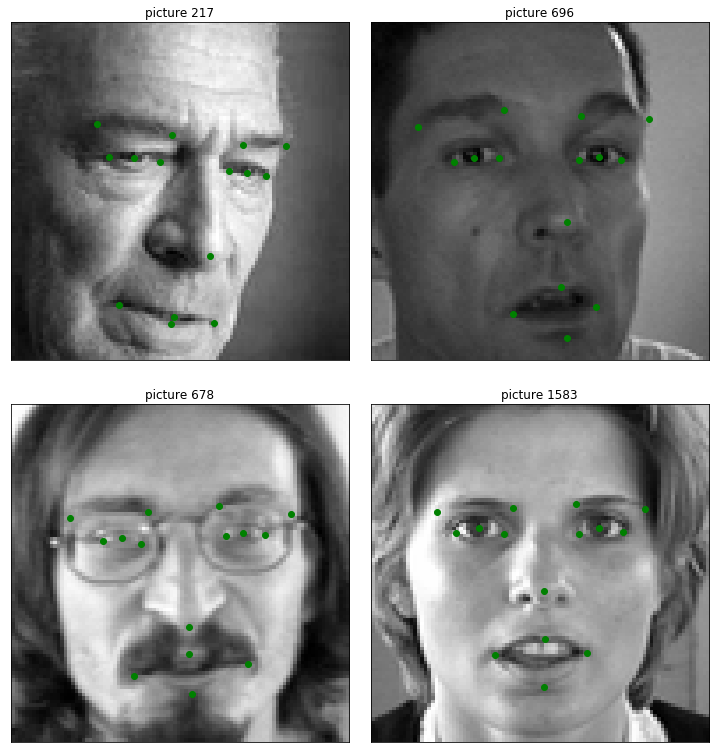

In [92]:
# https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 4
count = 1
# show images randomly in a 2X2 grid
for irow in range(Npicture):
    ipic = np.random.choice(X.shape[0])
    # https://matplotlib.org/api/axes_api.html
    axs = fig.add_subplot(Npicture/2, 2, count, xticks=[], yticks=[])
    # plot an image and its features
    plot_sample(X[ipic], y[ipic], axs, color='g')
    axs.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [95]:
%%time
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

def SimpleNN():
    # Sequential Model: a linear stack of neural network layers.
    model = Sequential()
    '''
    Add NN layer: (2140, 9216) -> (2140, 100)
    '''
    model.add(Dense(100, input_dim=X.shape[1]))
    '''
    Add Activation layer: (2140, 100) -> (2140, 100)
    '''
    model.add(Activation('relu'))
    '''
    Add NN layer: (2140, 100) -> (2140, 30)
    '''
    model.add(Dense(30))

    '''
    Optimizer SGD: 
        learning rate: 0.01
        momentum: 0.9
        apply Nesterov momentum: true
    Loss Function: MSE
    '''
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model

'''
Train the model.
validation_split -> use 20% of the training data for evaluation after each epoch
history.history -> loss, val_loss(validation loss)
'''
model = SimpleNN()
history = model.fit(X, y, epochs=100, validation_split=0.2,verbose=False)

# save model
save_model(model, "BasicNN")

CPU times: user 1min 20s, sys: 14 s, total: 1min 34s
Wall time: 33.9 s


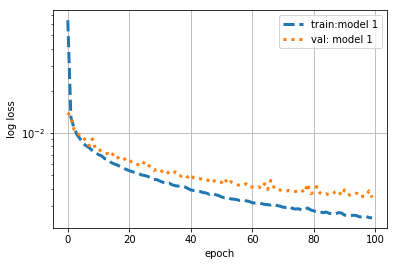

In [74]:
plot_loss(history.history, "model 1", plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

In [101]:
# load X from test dataset
X_test , _ = load(test=True)

# reload model
model = load_model("BasicNN")
y_test = model.predict(X_test)
print("X_test type: %s, y_test type: %s" % (type(X_test), type(y_test)))
print("X_test.shape == {}; X_test.min == {:.3f}; X_test.max == {:.3f}".format(X_test.shape, X_test.min(), X_test.max()))
print("y_test.shape == {}; y_test.min == {:.3f}; y_test.max == {:.3f}".format(y_test.shape, y_test.min(), y_test.max()))

X_test.shape == (1783, 9216); X_test.min == 0.000; X_test.max == 1.000
y_test.shape == (1783, 30); y_test.min == -1.030; y_test.max == 1.151


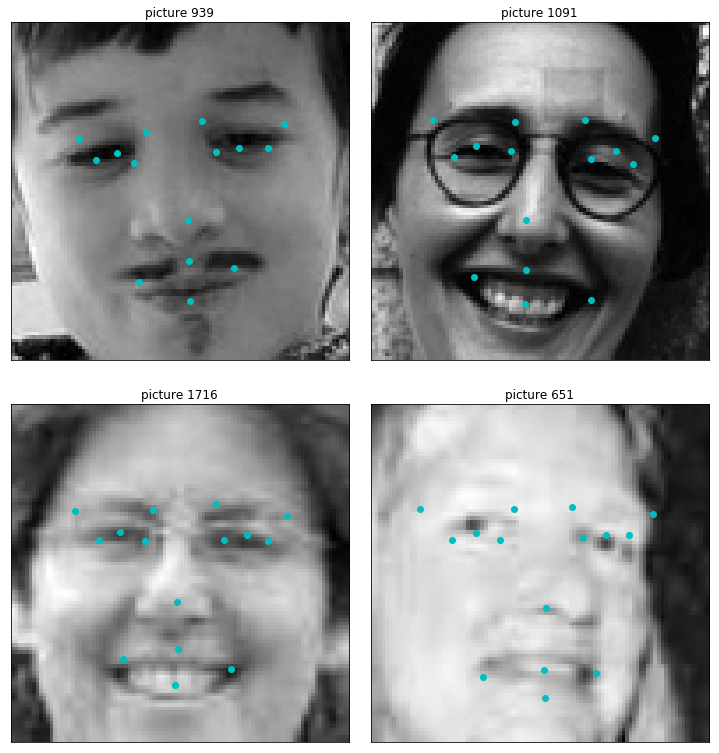

In [102]:
# https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 4
count = 1
# show images randomly in a 2X2 grid
for irow in range(Npicture):
    ipic = np.random.choice(X_test.shape[0])
    # https://matplotlib.org/api/axes_api.html
    axs = fig.add_subplot(Npicture/2, 2, count, xticks=[], yticks=[])
    # plot an image and its features
    plot_sample(X_test[ipic], y_test[ipic], axs, color='c')
    axs.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [132]:
# load data as 2-dim
X, y = load2d()
print("X type: %s, y type: %s" % (type(X), type(y)))
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("X[0]: %s" % str(X[0]))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))
print("y[0]: %s" % str(y[0]))

X type: <class 'numpy.ndarray'>, y type: <class 'numpy.ndarray'>
X.shape == (10, 96, 96, 1); X.min == 0.000; X.max == 1.000
X[0]: [[[0.6431373 ]
  [0.61960787]
  [0.4627451 ]
  ...
  [0.73333335]
  [0.73333335]
  [0.7294118 ]]

 [[0.63529414]
  [0.5411765 ]
  [0.3529412 ]
  ...
  [0.73333335]
  [0.7372549 ]
  [0.7294118 ]]

 [[0.6039216 ]
  [0.44313726]
  [0.2901961 ]
  ...
  [0.73333335]
  [0.73333335]
  [0.7254902 ]]

 ...

 [[0.05882353]
  [0.02745098]
  [0.04705882]
  ...
  [0.42352942]
  [0.5568628 ]
  [0.54509807]]

 [[0.05882353]
  [0.03529412]
  [0.02352941]
  ...
  [0.3764706 ]
  [0.47843137]
  [0.59607846]]

 [[0.05882353]
  [0.04313726]
  [0.02745098]
  ...
  [0.33333334]
  [0.4       ]
  [0.5411765 ]]]
y.shape == (10, 30); y.min == -0.753; y.max == 0.956
y[0]: [ 0.37089333 -0.27593333 -0.42758667 -0.24613333  0.22192    -0.22230667
  0.51985335 -0.25209334 -0.24286667 -0.22826667 -0.57656    -0.21634667
  0.19808    -0.47853333  0.6515333  -0.40345332 -0.24286667 -0.4546933

X type: <class 'numpy.ndarray'>, y type: <class 'numpy.ndarray'>
X.shape == (10, 96, 96, 1); X.min == 0.000; X.max == 1.000
X[0]: [[[0.6431373 ]
  [0.61960787]
  [0.4627451 ]
  ...
  [0.73333335]
  [0.73333335]
  [0.7294118 ]]

 [[0.63529414]
  [0.5411765 ]
  [0.3529412 ]
  ...
  [0.73333335]
  [0.7372549 ]
  [0.7294118 ]]

 [[0.6039216 ]
  [0.44313726]
  [0.2901961 ]
  ...
  [0.73333335]
  [0.73333335]
  [0.7254902 ]]

 ...

 [[0.05882353]
  [0.02745098]
  [0.04705882]
  ...
  [0.42352942]
  [0.5568628 ]
  [0.54509807]]

 [[0.05882353]
  [0.03529412]
  [0.02352941]
  ...
  [0.3764706 ]
  [0.47843137]
  [0.59607846]]

 [[0.05882353]
  [0.04313726]
  [0.02745098]
  ...
  [0.33333334]
  [0.4       ]
  [0.5411765 ]]]
y.shape == (10, 30); y.min == -0.753; y.max == 0.956
y[0]: [ 0.37089333 -0.27593333 -0.42758667 -0.24613333  0.22192    -0.22230667
  0.51985335 -0.25209334 -0.24286667 -0.22826667 -0.57656    -0.21634667
  0.19808    -0.47853333  0.6515333  -0.40345332 -0.24286667 -0.4546933

In [ ]:
from keras.layers import Conv2D, MaxPooling2D,Flatten, Dropout

def SimpleCNN(withDropout=False):
    '''
    WithDropout: If True, then dropout regularlization is added.
    This feature is experimented later.
    '''
    model = Sequential()
    # https://keras.io/layers/convolutional/
    '''
    Conv Layer: 32 Filters w/ 3X3 window
    Input Layer: 96 X 96 X 1 Image
    '''
    model.add(Conv2D(32, (3, 3), input_shape = (96, 96, 1)))
    '''
    O = Output heigth(width)
    W = Input height(Width)
    K = Filter height(width)
    P = Padding
    S = Stride
    =====================================
        O = (W - K + 2P) / S + 1
    =====================================
    
    (96 - 3 + 2*0) / 1 + 1 = 94
    '''
    model.add(Activation('relu')) ## 96 - 3 + 2
    
    # https://keras.io/layers/pooling/
    '''
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
    
    94 / 2 = 47
    '''
    model.add(MaxPooling2D(pool_size = (2,2))) ## 96 - (3-1)*2
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Conv2D(64,(2,2)))
    model.add(Activation('relu')) ## 
    model.add(MaxPooling2D(pool_size = (2,2)))
    if withDropout:
        model.add(Dropout(0.1))
    
    model.add(Conv2D(128,(2,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Flatten())
    
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(500))
    model.add(Activation('relu'))
    if withDropout:
        model.add(Dropout(0.1))
        
    model.add(Dense(30))
    sgd = SGD(lr=0.01,momentum = 0.9,nesterov=True)
    model.compile(loss="mean_squared_error",optimizer=sgd)
    return(model)